In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import wilcoxon

sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)

In [2]:
def create_id(results):
  solutions = results['Solution'].unique()
  solution_to_id = {solution: f"S{i}" for i, solution in enumerate(solutions)}
  results['Solution'] = results['Solution'].map(solution_to_id)

def compute_win_stat(results, baseline, metric):
  sol_stats = {}

  for s in results['Solution'].unique():
      if s == 'Baseline':
        continue
      count = 0
      loss = 0
      tie = 0
      for f in results['File'].unique():
        stat = wilcoxon(
          results[(results['File'] == f) & (results['Solution'] == s)][metric],
          baseline[baseline['File'] == f][metric],
          alternative='greater'
        )
        if stat['p-val'].values[0] < 0.05:
          count += 1
        elif stat['p-val'].values[0] > 0.99:
          loss += 1
        else:
          tie += 1
      sol_stats[s] = { 'win': count, 'tie': tie, 'loss': loss }
  return sol_stats

# RQ1: Training

In [3]:
grid_search = pd.read_csv('training/grid_sreach_results.csv')
grid_search.set_index('Parameter Set', inplace=True)
grid_search['Solution'] = 'Dominated'

In [4]:
pareto = pd.read_csv('training/pareto_front_results.csv')
pareto.set_index('Parameter Set', inplace=True)
pareto['Solution'] = 'Pareto'

In [5]:
grid_search.drop(pareto.index, inplace=True)

In [6]:
solutions = pd.concat([grid_search, pareto])
solutions

,Parameters,Cosine Similarity,BERT Score (F1),Solution
Parameter Set,,,,
1,"{'temperature': 0.6, 'top_k': None, 'top_p': 0...",0.176867,0.743901,Dominated
2,"{'temperature': 0.6, 'top_k': None, 'top_p': 0...",0.559563,0.776538,Dominated
3,"{'temperature': 0.6, 'top_k': None, 'top_p': 0...",0.552578,0.796361,Dominated
4,"{'temperature': 0.6, 'top_k': None, 'top_p': 0...",0.548549,0.755779,Dominated
5,"{'temperature': 0.6, 'top_k': None, 'top_p': 1...",0.355428,0.739442,Dominated
...,...,...,...,...
43,"{'temperature': 0.7999999999999999, 'top_k': 5...",0.911361,0.825196,Pareto
69,"{'temperature': 0.9999999999999999, 'top_k': N...",0.872345,0.880197,Pareto
81,"{'temperature': 1.0999999999999999, 'top_k': N...",0.873458,0.832510,Pareto


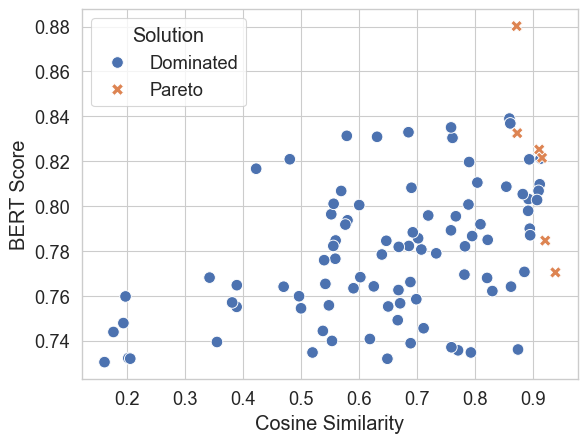

In [11]:
fig, ax = plt.subplots()
sns.scatterplot(data=solutions, x='Cosine Similarity', y='BERT Score (F1)', hue='Solution', style='Solution', s=70, ax=ax)
ax.yaxis.set_label_text('BERT Score')
ax.xaxis.set_label_text('Cosine Similarity')
plt.savefig('pareto_front.pdf')
plt.show()

In [168]:
baseline = pd.read_csv('training/baseline_updated.csv')
plot_data = pd.concat([pareto, baseline])

In [170]:
plot_data['Solution'] = plot_data['Solution'].fillna('Baseline')

In [172]:
plot_data_melt = pd.melt(plot_data, id_vars=['Solution'], value_vars=['Cosine Similarity', 'BERT Score (F1)'])

,Solution,variable,value
0,Pareto,Cosine Similarity,0.921735
1,Pareto,Cosine Similarity,0.911361
2,Pareto,Cosine Similarity,0.872345
3,Pareto,Cosine Similarity,0.873458
4,Pareto,Cosine Similarity,0.916272
5,Pareto,Cosine Similarity,0.939285
6,Baseline,Cosine Similarity,0.014979
7,Baseline,Cosine Similarity,0.303279
8,Baseline,Cosine Similarity,0.179493
9,Baseline,Cosine Similarity,0.040905


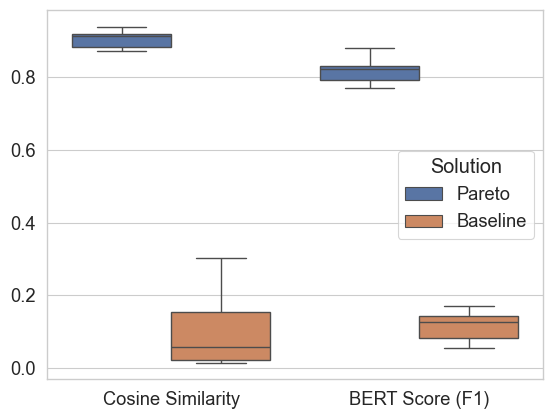

In [181]:
ax = sns.boxplot(
  data=plot_data_melt,
  x='variable',
  y='value',
  hue='Solution',
)
ax.yaxis.set_label_text('')
ax.xaxis.set_label_text('')
plt.savefig('boxplot_train.pdf')
plt.show()

# RQ2: Generalizability

In [55]:
baseline = pd.read_csv('zero-shot/baseline.csv')

In [56]:
results = pd.read_csv('zero-shot/results.csv')
results

,File,Solution,Cosine,BERT
0,10_HBMS.docx,"{'temperature': 0.6, 'top_k': 50, 'top_p': 1.0...",0.853066,0.893256
1,10_HBMS.docx,"{'temperature': 0.6, 'top_k': 50, 'top_p': 1.0...",0.853066,0.884642
2,10_HBMS.docx,"{'temperature': 0.6, 'top_k': 50, 'top_p': 1.0...",0.853066,0.888773
3,10_HBMS.docx,"{'temperature': 0.6, 'top_k': 50, 'top_p': 1.0...",0.853066,0.915135
4,10_HBMS.docx,"{'temperature': 0.6, 'top_k': 50, 'top_p': 1.0...",0.853066,0.911514
...,...,...,...,...
595,08_Block.docx,"{'temperature': 1.1, 'top_k': 50, 'top_p': 0.9...",0.717769,0.898185
596,08_Block.docx,"{'temperature': 1.1, 'top_k': 50, 'top_p': 0.9...",0.717769,0.890098
597,08_Block.docx,"{'temperature': 1.1, 'top_k': 50, 'top_p': 0.9...",0.717769,0.894356
598,08_Block.docx,"{'temperature': 1.1, 'top_k': 50, 'top_p': 0.9...",0.717769,0.873535


In [57]:
create_id(results)

In [58]:
results_melt = pd.melt(results, id_vars=['File', 'Solution'], var_name='Metric', value_name='Value')

In [62]:
cos_baseline = baseline['Cosine'].mean()
bert_baseline = baseline['BERT'].mean()

/Users/giord/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


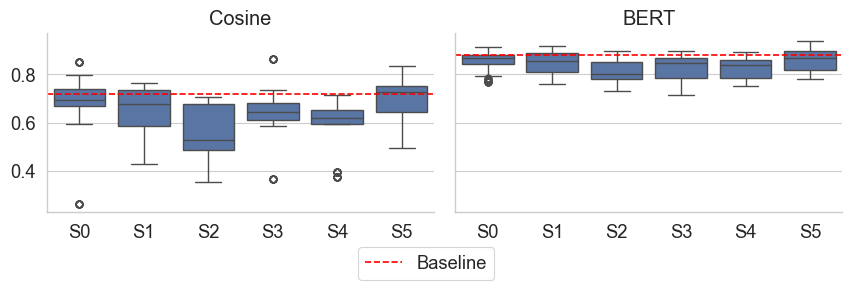

In [116]:
g = sns.FacetGrid(col='Metric', data=results_melt, aspect=1.5)
g.map(sns.boxplot, 'Solution', 'Value')
g.set_titles('{col_name}')
g.axes[0, 0].axhline(cos_baseline, color='red', linestyle='--', label='Baseline')
g.axes[0, 1].axhline(bert_baseline, color='red', linestyle='--')
g.figure.legend(loc='lower center')
g.set_axis_labels('', '')
plt.savefig('zero-shot/zero-shot-boxplot.pdf')
plt.show()

## Analysis of the best pareto-solutions

In [66]:
sol_stats_cosine = compute_win_stat(results, baseline, 'Cosine')

In [67]:
stats = pd.DataFrame(sol_stats_cosine).T
stats['Cosine'] = stats.apply(lambda x: f"{x['win']} / {x['tie']} / {x['loss']}", axis=1)
stats = stats.drop(columns=['win', 'tie', 'loss'])

In [68]:
stats

,Cosine
S0,4 / 0 / 6
S1,1 / 0 / 9
S2,1 / 1 / 8
S3,3 / 0 / 7
S4,1 / 1 / 8
S5,4 / 0 / 6


In [69]:
sol_stats_bert = compute_win_stat(results, baseline, 'BERT')

In [70]:
stats_bert = pd.DataFrame(sol_stats_bert).T
stats_bert['BERT'] = stats_bert.apply(lambda x: f"{x['win']} / {x['tie']} / {x['loss']}", axis=1)
stats_bert = stats_bert.drop(columns=['win', 'tie', 'loss'])
stats = pd.concat([stats, stats_bert], axis=1)
stats.to_latex('zero-shot/stats.tex')

## Analysis of domain models

In [36]:
def get_best_domain_model(results, metric):
  best = {}
  for f in results['File'].unique():
    count = 0
    for s in results['Solution'].unique():
      if s == 'Baseline':
        continue
      else:
        stat = wilcoxon(
          results[(results['File'] == f) & (results['Solution'] == s)][metric],
          results[(results['File'] == f) & (results['Solution'] == 'Baseline')][metric],
          alternative='greater'
        )
        if stat['p-val'].values[0] < 0.05:
          count += 1
    best[f] = count/len(results['Solution'].unique())
  return best

In [37]:
sol_stats_cosine = get_best_domain_model(results, 'Cosine')

In [38]:
sol_stats_cosine

{'10_HBMS.docx': 0.42857142857142855,
 '07_OTS.docx': 0.0,
 '06_SHAS.docx': 0.14285714285714285,
 '01_BTMS.docx': 0.2857142857142857,
 '03_LabTracker.docx': 0.14285714285714285,
 '04_CelO.docx': 0.7142857142857143,
 '09_TileO.docx': 0.0,
 '02_H2S.docx': 0.2857142857142857,
 '05_TSS.docx': 0.0,
 '08_Block.docx': 0.0}

In [40]:
baseline.describe()

,Cosine,BERT
count,100.000000,100.000000
mean,0.719834,0.879534
std,0.072146,0.045098
min,0.587575,0.787876
25%,0.648020,0.833534
50%,0.746207,0.896776
75%,0.776291,0.911111
max,0.819809,0.946621


In [39]:
sol_stats_bert = get_best_domain_model(results, 'BERT')
sol_stats_bert

{'10_HBMS.docx': 0.42857142857142855,
 '07_OTS.docx': 0.0,
 '06_SHAS.docx': 0.14285714285714285,
 '01_BTMS.docx': 0.42857142857142855,
 '03_LabTracker.docx': 0.0,
 '04_CelO.docx': 0.0,
 '09_TileO.docx': 0.0,
 '02_H2S.docx': 0.2857142857142857,
 '05_TSS.docx': 0.0,
 '08_Block.docx': 0.0}

# RQ3: Prompt Style

## Chain of Thought

In [73]:
cot_ris = pd.read_csv('cot/cot-results.csv')
cot_baseline = pd.read_csv('cot/cot-baseline.csv')
# cot_ris = preprocess(cot_ris, cot_baseline)

In [75]:
create_id(cot_ris)

In [95]:
cot_ris_melt = pd.melt(cot_ris, id_vars=['Solution', 'File'], var_name='Metric', value_name='Value')

In [97]:
cot_ris_melt

,Solution,File,Metric,Value
0,S0,10_HBMS.docx,Cosine,0.916943
1,S0,10_HBMS.docx,Cosine,0.898438
2,S0,10_HBMS.docx,Cosine,0.894989
3,S0,10_HBMS.docx,Cosine,0.929443
4,S0,10_HBMS.docx,Cosine,0.895401
...,...,...,...,...
1195,S5,08_Block.docx,BERT,0.793114
1196,S5,08_Block.docx,BERT,0.783701
1197,S5,08_Block.docx,BERT,0.764506
1198,S5,08_Block.docx,BERT,0.769571


/Users/giord/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


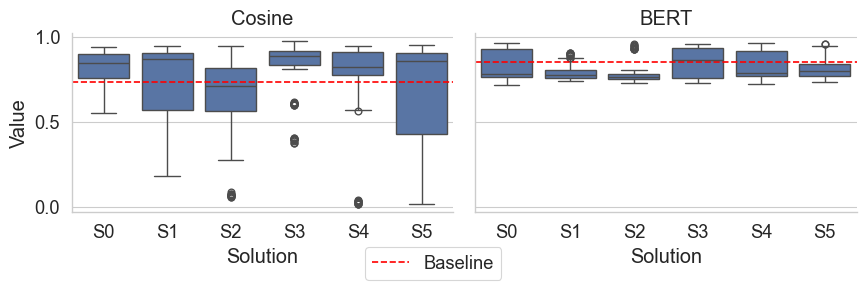

In [117]:
g = sns.FacetGrid(col='Metric', data=cot_ris_melt, sharey=True, sharex=True, aspect=1.5)
g.map(sns.boxplot, 'Solution', 'Value')
g.set_titles('{col_name}')
g.axes[0, 0].axhline(cot_baseline['Cosine'].mean(), color='red', linestyle='--', label='Baseline')
g.axes[0, 1].axhline(cot_baseline['BERT'].mean(), color='red', linestyle='--')
g.figure.legend(loc='lower center')
plt.savefig('cot/cot-boxplot.pdf')
plt.show()

In [119]:
sol_stats_cosine = compute_win_stat(cot_ris, baseline, 'Cosine')
sol_stats_cosine = pd.DataFrame(sol_stats_cosine).T

In [120]:
sol_stats_bert = compute_win_stat(cot_ris, baseline, 'BERT')
sol_stats_bert = pd.DataFrame(sol_stats_bert).T

In [121]:
sol_stats_cosine['Cosine'] = sol_stats_cosine.apply(lambda x: f"{x['win']} / {x['tie']} / {x['loss']}", axis=1)
sol_stats_cosine = sol_stats_cosine.drop(columns=['win', 'tie', 'loss'])
sol_stats_bert['BERT'] = sol_stats_bert.apply(lambda x: f"{x['win']} / {x['tie']} / {x['loss']}", axis=1)
sol_stats_bert = sol_stats_bert.drop(columns=['win', 'tie', 'loss'])
stats = pd.concat([sol_stats_cosine, sol_stats_bert], axis=1)

In [131]:
stats

,Cosine,BERT
S0,7 / 1 / 2,4 / 0 / 6
S1,6 / 1 / 3,1 / 0 / 9
S2,6 / 0 / 4,1 / 0 / 9
S3,8 / 0 / 2,5 / 0 / 5
S4,6 / 2 / 2,3 / 0 / 7
S5,7 / 0 / 3,2 / 1 / 7


In [123]:
stats.to_latex('cot/cot-stats.tex')

## Few Shot

In [127]:
few_shot = pd.read_csv('few-shot/fs-results.csv')
few_shot_baseline = pd.read_csv('few-shot/fs-baseline.csv')
create_id(few_shot)

In [128]:
few_shot_melt = pd.melt(few_shot, id_vars=['Solution', 'File'], var_name='Metric', value_name='Value')

/Users/giord/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


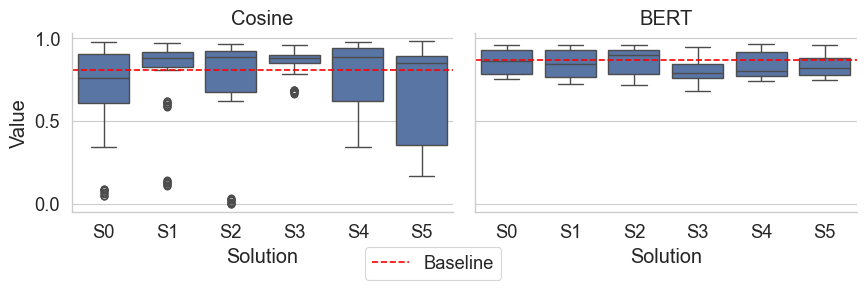

In [130]:
g = sns.FacetGrid(col='Metric', data=few_shot_melt, sharey=True, sharex=True, aspect=1.5)
g.map(sns.boxplot, 'Solution', 'Value')
g.set_titles('{col_name}')
g.axes[0, 0].axhline(few_shot_baseline['Cosine'].mean(), color='red', linestyle='--', label='Baseline')
g.axes[0, 1].axhline(few_shot_baseline['BERT'].mean(), color='red', linestyle='--')
g.figure.legend(loc='lower center')
plt.savefig('few-shot/fs-boxplot.pdf')
plt.show()

In [133]:
fs_stats_cosine = compute_win_stat(few_shot, baseline, 'Cosine')
fs_stats_cosine = pd.DataFrame(fs_stats_cosine).T

In [134]:
fs_stats_cosine

,win,tie,loss
S0,5,0,5
S1,8,0,2
S2,6,1,3
S3,9,0,1
S4,6,1,3
S5,7,0,3


In [135]:
fs_stats_bert = compute_win_stat(few_shot, baseline, 'BERT')
fs_stats_bert = pd.DataFrame(fs_stats_bert).T

In [136]:
fs_stats_bert

,win,tie,loss
S0,5,1,4
S1,4,0,6
S2,4,2,4
S3,2,0,8
S4,3,0,7
S5,3,0,7


In [137]:
fs_stats_cosine['Cosine'] = fs_stats_cosine.apply(lambda x: f"{x['win']} / {x['tie']} / {x['loss']}", axis=1)
fs_stats_cosine = fs_stats_cosine.drop(columns=['win', 'tie', 'loss'])
fs_stats_bert['BERT'] = fs_stats_bert.apply(lambda x: f"{x['win']} / {x['tie']} / {x['loss']}", axis=1)
fs_stats_bert = fs_stats_bert.drop(columns=['win', 'tie', 'loss'])
stats = pd.concat([fs_stats_cosine, fs_stats_bert], axis=1)

In [138]:
stats

,Cosine,BERT
S0,5 / 0 / 5,5 / 1 / 4
S1,8 / 0 / 2,4 / 0 / 6
S2,6 / 1 / 3,4 / 2 / 4
S3,9 / 0 / 1,2 / 0 / 8
S4,6 / 1 / 3,3 / 0 / 7
S5,7 / 0 / 3,3 / 0 / 7


In [139]:
stats.to_latex('few-shot/fs-stats.tex')